In [1]:
# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'CV7062610/assignments/assignment3/'
FOLDERNAME = "assignment2"
assert FOLDERNAME is not None, "[!] Enter the foldername."
"""
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/CV7062610/datasets/
!bash get_datasets.sh
%cd /content
"""

"\n# this mounts your Google Drive to the Colab VM.\nfrom google.colab import drive\ndrive.mount('/content/drive', force_remount=True)\n\n\n\n# now that we've mounted your Drive, this ensures that\n# the Python interpreter of the Colab VM can load\n# python files from within it.\nimport sys\nsys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))\n\n# this downloads the CIFAR-10 dataset to your Drive\n# if it doesn't already exist.\n%cd drive/My\\ Drive/$FOLDERNAME/CV7062610/datasets/\n!bash get_datasets.sh\n%cd /content\n"

# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

 
After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth,(in the second part of the assingment) we will explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from CV7062610.classifiers.fc_net import *
from CV7062610.data_utils import get_CIFAR10_data
from CV7062610.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from CV7062610.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [3]:
a=np.array([1,1,1])
b=np.arange(18).reshape((3,6))


In [4]:
a@b/3, b.mean(axis=0),b

(array([ 6.,  7.,  8.,  9., 10., 11.]),
 array([ 6.,  7.,  8.,  9., 10., 11.]),
 array([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]]))

In [5]:
a@((b-a@b/3)**2)/3,b.var(axis=0)

(array([24., 24., 24., 24., 24., 24.]), array([24., 24., 24., 24., 24., 24.]))

In [6]:
for i in range(10):
    b = np.random.rand(np.random.randint(1,1000),np.random.randint(1,1000))*10000 - 10000
    a = np.ones(b.shape[0])
    print("mean:",np.sum(np.abs((a@b/b.shape[0])-b.mean(axis=0))))
    print("var:",np.sum(np.abs((a@((b-a@b/b.shape[0])**2)/b.shape[0])-b.var(axis=0))))

mean: 0.0
var: 0.0
mean: 0.0
var: 0.0
mean: 0.0
var: 0.0
mean: 0.0
var: 0.0
mean: 0.0
var: 0.0
mean: 0.0
var: 0.0
mean: 8.36735125631094e-11
var: 2.1327286958694458e-07
mean: 0.0
var: 0.0
mean: 0.0
var: 0.0
mean: 0.0
var: 0.0


In [7]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer (fully-conected): forward
Open the file `CV7062610/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [8]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))



Testing affine_forward function:
difference:  9.769848888397517e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [9]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  7.736978834487815e-12


# bachnorm layer: backward


In [10]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(20, 3)
gamma = np.random.randn(3)
beta = np.random.randn(3)
dout = np.random.randn(20, 3)
bn_params={}
bn_params["mode"]='check'

dx_num = eval_numerical_gradient_array(lambda x: bachnorm_foward(x, gamma,beta, bn_params)[0], x, dout)

dgamma_num = eval_numerical_gradient_array(lambda gamma: bachnorm_foward(x, gamma,beta, bn_params)[0], gamma, dout)
dbeta_num = eval_numerical_gradient_array(lambda beta: bachnorm_foward(x, gamma,beta, bn_params)[0], beta, dout)

_, cache = bachnorm_foward(x, gamma, beta,bn_params)
dx, dgamma, dbeta = bachnorm_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dgamma_num, dgamma))
print('db error: ', rel_error(dbeta_num, dbeta))
print(dx_num,dx)

Testing affine_backward function:
dx error:  2.741874043266423e-09
dw error:  1.4866816289494283e-11
db error:  3.2756955047236707e-12
[[ 4.21698099e+00  8.88614892e-02  5.99731122e-01]
 [-9.98862658e-01 -1.62357556e-01  2.30464377e-03]
 [-1.74242767e-01  2.93993602e-01  4.59395517e-01]
 [-1.13383461e+00  2.70282856e-02 -7.78963893e-01]
 [ 5.52954478e-03 -1.93912610e-01 -6.25584154e-01]
 [ 3.38350356e-02 -1.40124044e-02  5.96860455e-01]
 [-3.25597285e+00  1.13751677e-01  4.99200290e-01]
 [ 5.97252799e-01 -1.38739710e+00  8.41235921e-01]
 [ 1.93132571e+00  2.16353168e-01 -1.09558713e+00]
 [ 7.82276344e-02 -1.52356658e-01 -1.22670491e+00]
 [-2.29667964e+00  2.19024071e-01 -6.14110102e-01]
 [-1.31846759e+00  7.40489907e-02 -7.20622921e-01]
 [ 1.36663490e+00  4.07999488e-01  2.78298289e-01]
 [ 6.80293274e-01  2.10689517e-01 -2.18965386e-02]
 [-1.94647773e+00  1.65682652e-02  2.84019446e-02]
 [ 7.27054874e-01  2.63818530e-01  1.02290461e+00]
 [ 2.03591014e+00 -3.30193505e-01  2.98144768e-03

# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [11]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [12]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
[FILL THIS IN]


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `CV7062610/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [13]:
from CV7062610.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.395535042049294e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax
You implemented this loss functions in the last assignment, so we'll give it to you for free here. You should still make sure you understand how it work by looking at the implementations in `CV7062610/layers.py`.

You can make sure that the implementations are correct by running the following:

In [14]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))



Testing softmax_loss:
loss:  2.3025458445007376
dx error:  6.2243422477091075e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `CV7062610
/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [15]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.34e-10
b1 relative error: 8.01e-09
b2 relative error: 2.53e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 3.12e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 1.97e-09


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `CV7062610/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `45%` accuracy on the validation set. If you are doing it corectly this shouldn't take more than 5 epochs of training and more than 5 minuts using vanilla sgd.

In [16]:
model = TwoLayerNet()
solver = None
best_val = -1
##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model,data=data,verbose=True,optim_config={"learning_rate":5e-4},lr_decay=1,num_epochs=5)
solver.train()
best_val = solver.best_val_acc #solver.check_accuracy(data['X_test'],data['y_test'])
best_val
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

c:\Users\Ziv\Desktop\University\year 3\semester 2\computer vision\Computer-vision-and-AI-ex-2\assignment2\CV7062610\solver.py:254: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train" failed type inference due to: non-precise type pyobject
During: typing of argument at c:\Users\Ziv\Desktop\University\year 3\semester 2\computer vision\Computer-vision-and-AI-ex-2\assignment2\CV7062610\solver.py (259)

File "CV7062610\solver.py", line 259:
    def train(self):
        <source elided>
        """
        num_train = self.X_train.shape[0]
        ^

  @jit(parallel=True)
c:\Users\Ziv\Desktop\University\year 3\semester 2\computer vision\Computer-vision-and-AI-ex-2\assignment2\CV7062610\solver.py:254: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "train" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "CV7062610\solver.py

(Iteration 1 / 2450) loss: 2.304060
(Epoch 0 / 5) train acc: 0.092000; val_acc: 0.073000
(Iteration 11 / 2450) loss: 2.286339
(Iteration 21 / 2450) loss: 2.247149
(Iteration 31 / 2450) loss: 2.175662
(Iteration 41 / 2450) loss: 2.122639
(Iteration 51 / 2450) loss: 2.145749
(Iteration 61 / 2450) loss: 2.069872
(Iteration 71 / 2450) loss: 2.082481
(Iteration 81 / 2450) loss: 1.978829
(Iteration 91 / 2450) loss: 1.932673
(Iteration 101 / 2450) loss: 1.898232
(Iteration 111 / 2450) loss: 1.854451
(Iteration 121 / 2450) loss: 1.831479
(Iteration 131 / 2450) loss: 1.823377
(Iteration 141 / 2450) loss: 1.880665
(Iteration 151 / 2450) loss: 1.808169
(Iteration 161 / 2450) loss: 1.832338
(Iteration 171 / 2450) loss: 1.725936
(Iteration 181 / 2450) loss: 1.739907
(Iteration 191 / 2450) loss: 1.761860
(Iteration 201 / 2450) loss: 1.935383
(Iteration 211 / 2450) loss: 1.785477
(Iteration 221 / 2450) loss: 1.822074
(Iteration 231 / 2450) loss: 1.735837
(Iteration 241 / 2450) loss: 1.593559
(Iterati

0.504

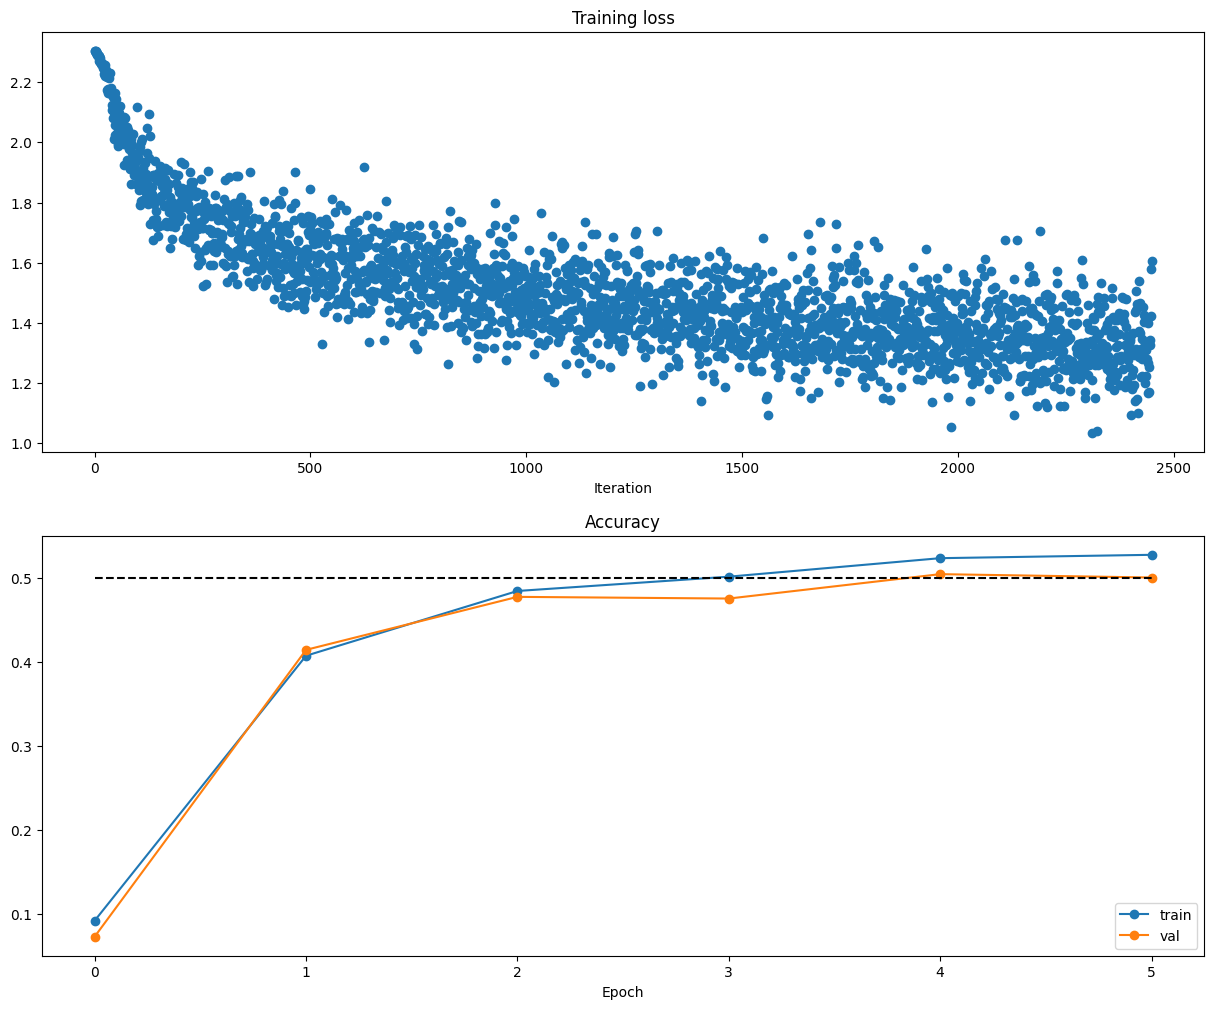

In [17]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `CV7062610/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [19]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 0.7,1,3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  
  
  

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 7.70e-08
W2 relative error: 1.01e-05
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.64e-10
Running check with reg =  0.7
Initial loss:  3.3606694235873547
W1 relative error: 4.71e-08
W2 relative error: 2.20e-07
W3 relative error: 1.66e-07
b1 relative error: 1.48e-08
b2 relative error: 9.48e-10
b3 relative error: 1.32e-10
Running check with reg =  1
Initial loss:  3.776019363337085
W1 relative error: 1.18e-07
W2 relative error: 1.10e-07
W3 relative error: 1.05e-07
b1 relative error: 4.45e-09
b2 relative error: 1.02e-08
b3 relative error: 1.25e-10
Running check with reg =  3.14
Initial loss:  6.704192305650366
W1 relative error: 7.47e-09
W2 relative error: 1.26e-08
W3 relative error: 9.18e-08
b1 relative error: 4.29e-07
b2 relative error: 1.83e-08
b3 relative error: 1.02e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.367249
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.124000
(Epoch 1 / 20) train acc: 0.420000; val_acc: 0.143000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.166000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.154000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.148000
(Epoch 5 / 20) train acc: 0.560000; val_acc: 0.147000
(Iteration 11 / 40) loss: 1.377840
(Epoch 6 / 20) train acc: 0.540000; val_acc: 0.180000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.198000
(Epoch 8 / 20) train acc: 0.800000; val_acc: 0.204000
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.219000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.224000
(Iteration 21 / 40) loss: 0.600724
(Epoch 11 / 20) train acc: 0.900000; val_acc: 0.214000
(Epoch 12 / 20) train acc: 0.860000; val_acc: 0.164000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.196000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.215000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.220000
(Iteration 31 / 40) loss: 

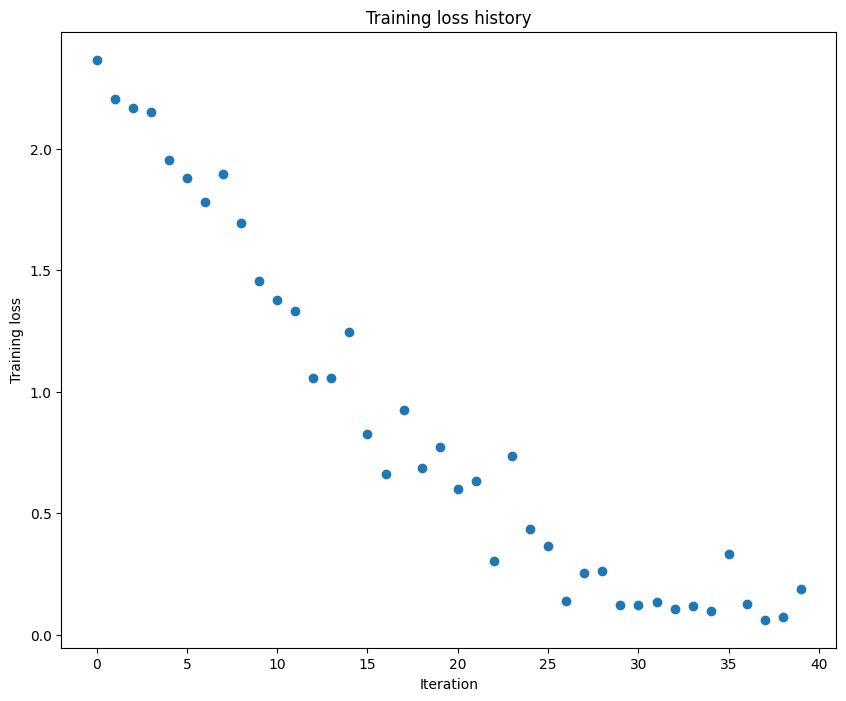

In [20]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

##### TODO: find the best lr and wight scale ##########
weight_scale = 1e-2   # Experiment with this!
learning_rate = 7.5e-3  # Experiment with this!
#######################################################
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 21.424857
(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.075000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.076000
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.280000; val_acc: 0.083000
(Epoch 4 / 20) train acc: 0.320000; val_acc: 0.076000
(Epoch 5 / 20) train acc: 0.420000; val_acc: 0.090000
(Iteration 11 / 40) loss: 4.284423
(Epoch 6 / 20) train acc: 0.540000; val_acc: 0.088000
(Epoch 7 / 20) train acc: 0.620000; val_acc: 0.091000
(Epoch 8 / 20) train acc: 0.700000; val_acc: 0.104000
(Epoch 9 / 20) train acc: 0.740000; val_acc: 0.105000
(Epoch 10 / 20) train acc: 0.800000; val_acc: 0.095000
(Iteration 21 / 40) loss: 0.558532
(Epoch 11 / 20) train acc: 0.840000; val_acc: 0.094000
(Epoch 12 / 20) train acc: 0.880000; val_acc: 0.090000
(Epoch 13 / 20) train acc: 0.900000; val_acc: 0.094000
(Epoch 14 / 20) train acc: 0.900000; val_acc: 0.096000
(Epoch 15 / 20) train acc: 0.920000; val_acc: 0.093000
(Iteration 31 / 40) loss:

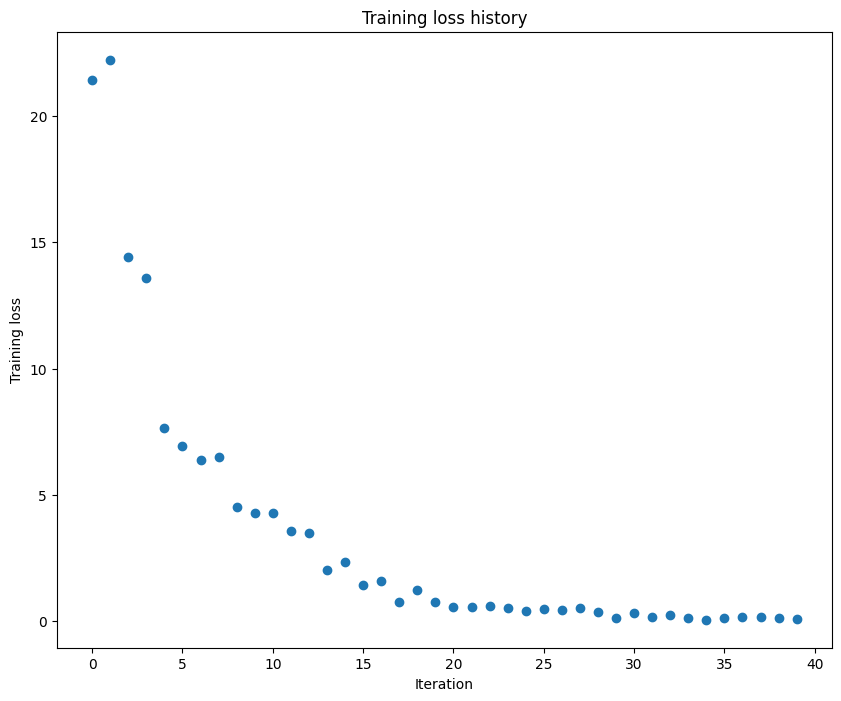

In [21]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

##### TODO: find the best lr and wight scale ##########
learning_rate = 4e-4  # Experiment with this!
weight_scale = 7e-2  # Experiment with this!
#######################################################
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 40% accuracy on the validation set using a fully-connected net. Using sgd this shouldn't take more than 5 minuts per traing over 10 epochs.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

In [26]:
best_model = None
best_val = 0.0
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
results = {}


learning_rates_count=5
learning_rates_ = [2e-6,3e-6]
learning_rates = np.linspace(learning_rates_[0],learning_rates_[1], endpoint=True,num=learning_rates_count)
learning_rates = [0.002]

regularization_strengths_count=5
regularization_strengths_ = [1e3,2e3]
regularization_strengths = np.linspace(regularization_strengths_[0],regularization_strengths_[1], endpoint=True,num=regularization_strengths_count)
regularization_strengths = [0.015]

hidden_dims = {"d1":[256,256,512],"d2":[256,256,256],"d3":[512,256,256]}
hidden_dims = {"d1":[512,512,256,256]}#,"d2":[512,256,256]}#,"d3":[512,512,256,256]}
weight_scales = [2e-3]#7e-2,3e-2#

batch_sizes = [256]
for ws in weight_scales:
    for k, dims in hidden_dims.items():
        for lr in learning_rates:
            for reg in regularization_strengths:
                results[(lr, reg, k,ws)] = 0
                
                
                model = FullyConnectedNet(dims,
                    weight_scale=ws, dtype=np.float64,reg=reg,normalization="batchnorm")
                solver = Solver(model, data,
                                print_every=100, num_epochs=10, batch_size=batch_sizes[0],
                                update_rule='sgd',
                                optim_config={
                                'learning_rate': lr,
                                }
                        )
                solver.train()
                
                val_accuracy = solver.best_val_acc

                results[(lr, reg, k,ws)] = val_accuracy
                if(val_accuracy > best_val):
                    best_val = val_accuracy
                    best_model = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 1910) loss: 2.364304
(Epoch 0 / 10) train acc: 0.101000; val_acc: 0.113000
(Iteration 101 / 1910) loss: 2.065237
(Epoch 1 / 10) train acc: 0.425000; val_acc: 0.417000
(Iteration 201 / 1910) loss: 1.827939
(Iteration 301 / 1910) loss: 1.561795
(Epoch 2 / 10) train acc: 0.447000; val_acc: 0.426000
(Iteration 401 / 1910) loss: 1.555886
(Iteration 501 / 1910) loss: 1.462794
(Epoch 3 / 10) train acc: 0.487000; val_acc: 0.473000
(Iteration 601 / 1910) loss: 1.472586
(Iteration 701 / 1910) loss: 1.330147
(Epoch 4 / 10) train acc: 0.570000; val_acc: 0.502000
(Iteration 801 / 1910) loss: 1.400396
(Iteration 901 / 1910) loss: 1.336049
(Epoch 5 / 10) train acc: 0.598000; val_acc: 0.517000
(Iteration 1001 / 1910) loss: 1.165196
(Iteration 1101 / 1910) loss: 1.165563
(Epoch 6 / 10) train acc: 0.606000; val_acc: 0.507000
(Iteration 1201 / 1910) loss: 1.165536
(Iteration 1301 / 1910) loss: 1.188259
(Epoch 7 / 10) train acc: 0.672000; val_acc: 0.543000
(Iteration 1401 / 1910) loss: 1.08

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [27]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.555
Test set accuracy:  0.514


In [28]:
print(results)

{(0.002, 0.015, 'd1', 0.002): 0.56}
